In [1]:
import os
import ee
import datetime
import tqdm
import json

import pandas as pd
import geopandas as gp
import numpy as np
import rsfuncs as rs

import scipy.interpolate as interp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

ee.Initialize()
%load_ext autoreload
%autoreload 2

In [2]:
# Read files, make polygons
kc = pd.read_csv('../data/fmp_kc_faunt.csv')
gdf = gp.read_file("../shape/cv.shp")
data = rs.load_data()

# Split cv into polygons
area = rs.gdf_to_ee_poly(gdf.simplify(0.01))
polys = rs.gen_polys(area, dx = 0.2, dy = 0.2)
polydict = polys.getInfo()

In [3]:
# Ensure each poly is a single geometry 

valid_polys = []

for i in tqdm(polydict['features'][:]):
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates'])# .intersection(area)
    pols = aoi.getInfo()['coordinates']
    if len(pols) == 0:
        continue
    if len(pols) == 1:
        valid_polys.append(ee.Geometry.Polygon(pols))
    if len(pols) > 1:
        for i in pols:
            print(i)
            valid_polys.append(ee.Geometry.Polygon(i))


In [4]:
# Helper functions 

def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']

    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = rs.array_from_df(df, var_name)
    
    return arr

def map_cdl2fmp(dictionary,array):
    '''maps values on cdl image to the fmp'''
    
    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        for i in v:
            if i == "":
                continue
            else:
                vec1.append(int(i))
                vec2.append(int(k))
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==k] =v
    
    return out_im


def map_fmp2kc(dictionary,array):
    '''maps values on fmp image to kc'''

    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        vec1.append(k)
        vec2.append(v)
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==k] =v
    
    return out_im



In [5]:
years = range(2010, 2011)
aoi = ee.Geometry.Polygon([[-120.022677908472,36.3243406268395],
                           [-119.822677908472,36.3243406268395],
                           [-119.822677908472,36.5243406268395],
                           [-120.022677908472,36.5243406268395],
                           [-120.022677908472,36.3243406268395]]) #valid_polys[137]

for y in years[:]:
    
    yearstart = "{}-01-01".format(str(y))
    yearend = "{}-12-31".format(str(y))
    
    # Select the correct or most recent CDL
    if y < 2008:
        cdl = ee.Image("USDA/NASS/CDL/2008")
    else:
        cdl = ee.Image("USDA/NASS/CDL/{}".format(str(y)))
    
    if y < 2013: 
#         landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_ANNUAL_NDWI").filterDate(yearstart, yearend).sum()
        landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_32DAY_NDWI").filterDate(yearstart, yearend).mean()

    if y >= 2013: 
#         landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_ANNUAL_NDWI").filterDate(yearstart, yearend).sum()
        landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_32DAY_NDWI").filterDate(yearstart, yearend).mean()

    # Compile CDL
    cdl_dat = ee.Image.pixelLonLat().addBands(cdl).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    cdl_dict = cdl_dat.getInfo()
    
    # Compile landsat NDWI 
    landsat_dat = ee.Image.pixelLonLat().addBands(landsat).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    landsat_dict = landsat_dat.getInfo()
    
    # Make the ims 
    cdl_im = dict2arr(cdl_dict, 'cropland')
    ndwi_im = dict2arr(landsat_dict, "NDWI")
    ndwi_im[ndwi_im<0] = 0
    
    # Map values from the CDL to the FMP
    mapping = rs.cdl_2_faunt()    
    fmp_im = map_cdl2fmp(mapping, cdl_im)
    
    # Map values from the FMP to kc (Schmid, 2004)    
    monthly_ims = []

    for i in kc.columns[2:]:
        kcvals = kc[i]
        kckeys =kc[kc.columns[0]]
        kcdict = dict(zip(kckeys, kcvals))
        kc_im = map_fmp2kc(kcdict, fmp_im)
        monthly_ims.append(kc_im)


In [6]:
# Plot images 

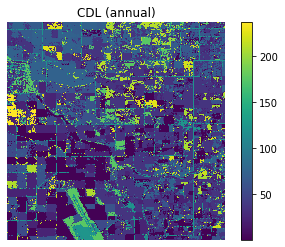

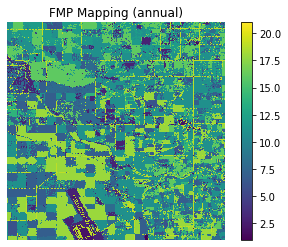

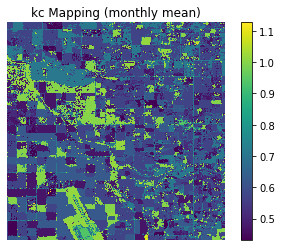

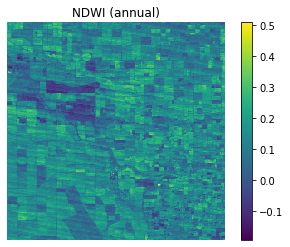

In [7]:
plt.title("CDL (annual)")
cdl_im[cdl_im == 0] = np.nan
plt.imshow(cdl_im)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("FMP Mapping (annual)")
fmp_im[fmp_im == 0] = np.nan
plt.imshow(fmp_im)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("kc Mapping (monthly mean)")
kc_mean = np.nanmean(np.dstack(monthly_ims), axis = 2)
kc_mean[ndwi_im == 0] = np.nan
plt.imshow(kc_mean)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("NDWI (annual)")
ndwi_im[ndwi_im == 0] = np.nan
plt.imshow(ndwi_im)
plt.axis("off")
plt.colorbar()
plt.show()



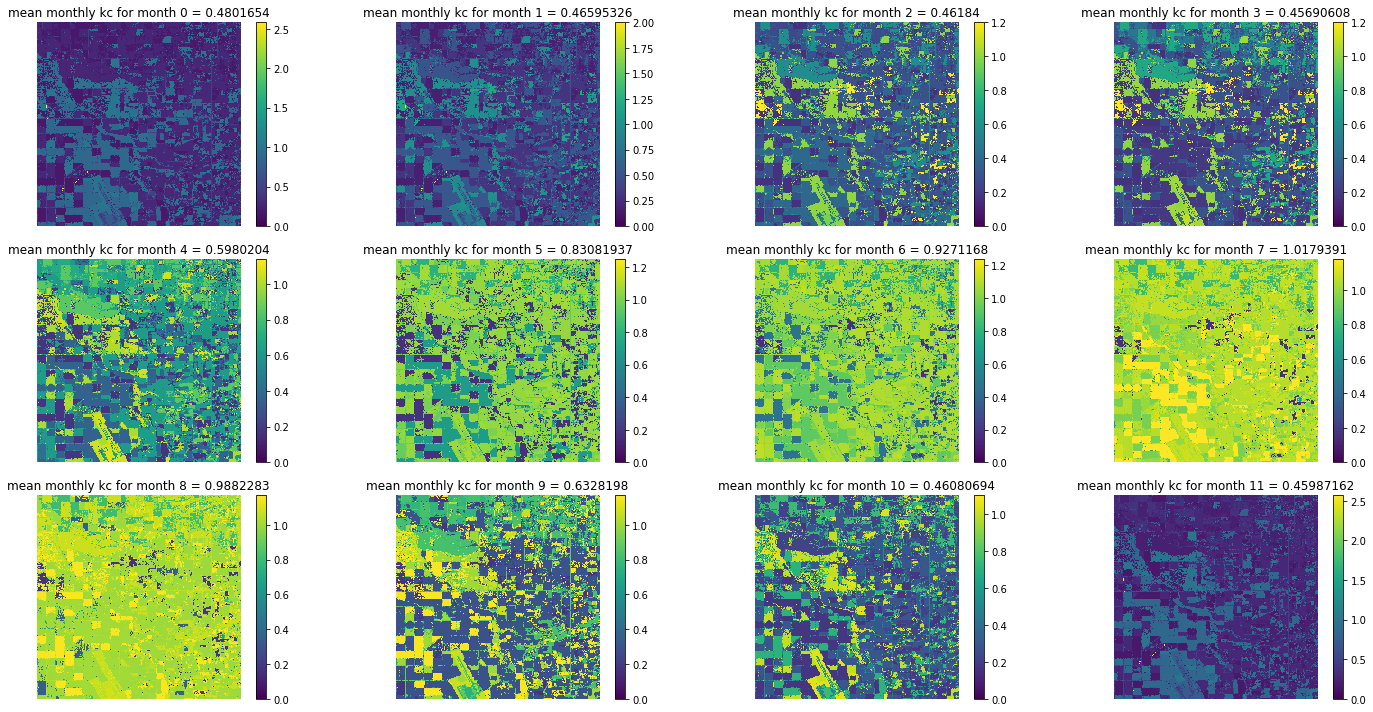

In [8]:
plt.figure(figsize=(20,10))

rows = 3
cols = 4

for idx,i in enumerate(monthly_ims):
    i[ndwi_im == np.nan] = np.nan
    plt.subplot(rows,cols,idx+1)
    plt.title("mean monthly kc for month {} = {}".format(str(idx),str(np.mean(i))))
    plt.axis('off')
    plt.imshow(i)
    plt.colorbar()
    
plt.tight_layout()

In [9]:
# Get aggregated stats and plot 

In [10]:
pets = []
aets = []

for i in tqdm([aoi]):
    pet = rs.calc_monthly_sum(data['modis_pet'], '2010-01-01', '2010-12-31', i)
    aet = rs.calc_monthly_sum(data['modis_aet'], '2010-01-01', '2010-12-31', i)

    pets.append(pet)
    aets.append(aet)


processing:
MODIS/006/MOD16A2/2001_01_01



processing:
MODIS/006/MOD16A2/2001_01_01


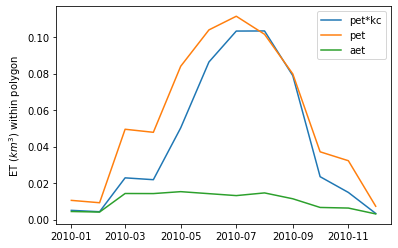

In [11]:
kc_means = np.array([np.mean(x) for x in monthly_ims])
plt.plot(kc_means.reshape(kc_means.shape[0],1)* pets[0], label = 'pet*kc')
plt.plot(pets[0], label = 'pet')
plt.plot(aets[0], label = "aet")

plt.ylabel("ET ($km^3$) within polygon")
plt.legend()

In [12]:
def get_monthly_et(dataset, start, end, aoi):
    '''
    Get gridded monthly ET sums from MODIS 
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]

    dt_idx = pd.date_range(start,end, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()
    
    for i in tqdm(num_steps[:]):

        t1 = ee.Date(start).advance(i, 'month')
        t2 = t1.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(t1, t2).sum().set('system:time_start', t1.millis()))
        modis_dat = im.pixelLonLat().addBands(im).reduceRegion(reducer=ee.Reducer.toList(),
                                                               geometry=aoi,
                                                               scale=1000, crs ='EPSG:4326')

        modis_dict = modis_dat.getInfo()
        modis_im = dict2arr(modis_dict, var)
        ims.append(modis_im)

    return ims

def resample_1km_30m(im_1km,im_30m):
    '''
    Interpolates 1 km modis data on to 30m landsat grid
    '''
    
    W, H = im_1km.shape[:2]
    new_W, new_H = im_30m.shape[:2]
    xrange = lambda x: np.linspace(0, 1, x)

    f = interp.interp2d(xrange(H), xrange(W), im_1km, kind="linear")
    new_arr = f(xrange(new_H), xrange(new_W))
    
    return new_arr

def interp_modis_nans(modis_image):
    '''
    interpolates nans in modis imagery. Doesn't work if a whole row/col at edge of image is all nans 
    '''
    # Get array dims
    W, H = modis_image.shape[:2]

    # Mask nans 
    array = np.ma.masked_invalid(modis_image)
    
    # Make the outgrid 
    xi = np.linspace(0, W, H)
    yi = np.linspace(0, W, H)
    xx, yy = np.meshgrid(xi, yi)

    # xx, yy = np.meshgrid(new_W, new_H)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    new_arr = interp.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
    
    return new_arr


def normalize_array(x):
    '''
    Force everything in an array between 0 and 1
    '''
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))


In [23]:
aetims = get_monthly_et(data['modis_aet'], '2009-01-01', '2009-12-31', aoi = aoi)
petims = get_monthly_et(data['modis_pet'], '2009-01-01', '2009-12-31', aoi = aoi)

In [24]:
petmean = np.nanmean(np.dstack(petims), axis = 2)
aetmean = np.nanmean(np.dstack(aetims), axis = 2)

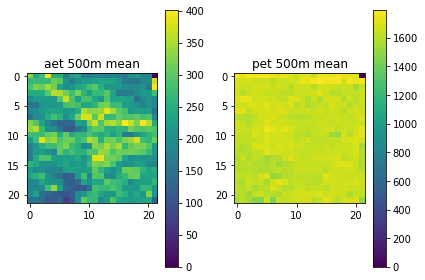

In [25]:
plt.subplot(121)
plt.imshow(aetmean)
plt.title("aet 500m mean")
plt.colorbar()
plt.subplot(122)
plt.title("pet 500m mean")
plt.imshow(petmean)
plt.colorbar()

plt.tight_layout()
plt.show()

In [26]:
pet_rs_mean = resample_1km_30m(petmean, kc_mean)
aet_rs_mean = resample_1km_30m(aetmean, kc_mean)

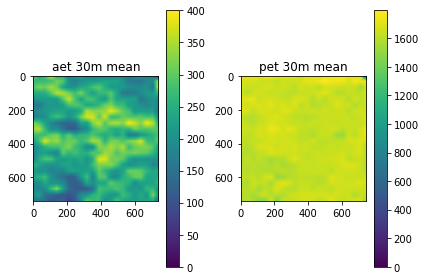

In [27]:
plt.subplot(121)
plt.imshow(aet_rs_mean)
plt.title("aet 30m mean")
plt.colorbar()
plt.subplot(122)
plt.title("pet 30m mean")
plt.imshow(pet_rs_mean)
plt.colorbar()

plt.tight_layout()
plt.show()

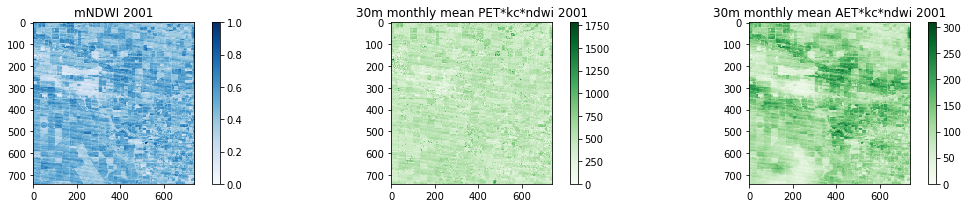

In [28]:
plt.figure(figsize=(15,3))

plt.subplot(131)
plt.imshow(normalize_array(ndwi_im), cmap = 'Blues')
plt.colorbar()
plt.title("mNDWI 2001")

plt.subplot(132)
plt.imshow(pet_rs_mean*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean PET*kc*ndwi 2001")

plt.subplot(133)
plt.imshow(aet_rs_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean AET*kc*ndwi 2001")

plt.tight_layout()
plt.show()


In [29]:
# ndwi_im[ndwi_im<0] = 0

In [30]:
# Compute wET like  $ [( (1- ndwi) * kc *aet ) + (ndwi * pet *kc)]$

mETs = []
for a,b,c in zip(petims, aetims, monthly_ims):
    pet_rs = resample_1km_30m(a, c)
    aet_rs = resample_1km_30m(b, c)
    mET =  (aet_rs* c * (1-(ndwi_im))) + (pet_rs * (ndwi_im)*c) 
    mETs.append(mET)

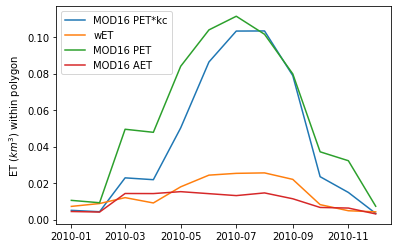

In [31]:
kc_means = np.array([np.mean(x) for x in monthly_ims])
mET_means = np.array([np.nanmean(x) for x in mETs])
metdf = pd.DataFrame([ mET_means*0.1]).T.set_index(pets[0].index) # scaling factor of 0.1
metkm3 = metdf* mETs[0].shape[0]*mETs[0].shape[1]*900 * 1e-12 # mm to km = 1e-6, m^2 to km^2 = 1e-6 

plt.plot(kc_means.reshape(kc_means.shape[0],1)* pets[0], label = 'MOD16 PET*kc')
plt.plot(metkm3, label = 'wET')
plt.plot(pets[0], label = 'MOD16 PET')
plt.plot(aets[0], label = "MOD16 AET")

plt.ylabel("ET ($km^3$) within polygon")
plt.legend()

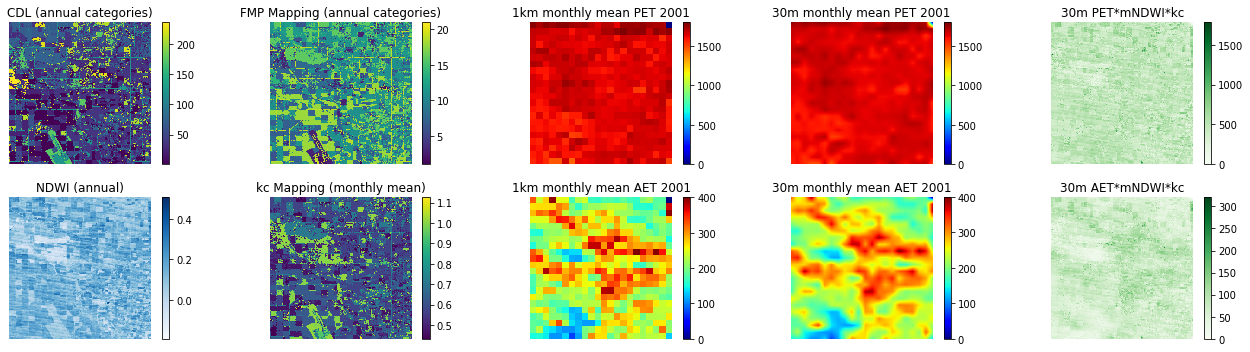

In [32]:
plt.figure(figsize=(18,5))
nrows = 2
ncols = 5

plt.subplot(nrows, ncols, 1)
plt.title("CDL (annual categories)")
plt.imshow(cdl_im)
plt.axis("off")
plt.colorbar()

plt.subplot(nrows, ncols,2)
plt.title("FMP Mapping (annual categories)")
plt.imshow(fmp_im)
plt.axis("off")
plt.colorbar()

plt.subplot(nrows, ncols,3)
plt.title("1km monthly mean PET 2001")
plt.imshow(petmean, cmap = 'jet')
plt.colorbar()
plt.axis("off")

plt.subplot(nrows, ncols,4)
plt.imshow(pet_rs_mean, cmap = 'jet')
plt.colorbar()
plt.title("30m monthly mean PET 2001")
plt.axis("off")

plt.subplot(nrows, ncols,5)
plt.imshow(pet_rs_mean*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m PET*mNDWI*kc")
plt.axis("off")

plt.subplot(nrows, ncols,6)
plt.title("NDWI (annual)")
plt.imshow(ndwi_im, cmap = "Blues")
plt.axis("off")
plt.colorbar()

plt.subplot(nrows, ncols,7)
plt.title("kc Mapping (monthly mean)")
plt.imshow(kc_mean)
plt.axis("off")
plt.colorbar()

plt.subplot(nrows, ncols,8)
plt.title("1km monthly mean AET 2001")
plt.imshow(aetmean, cmap = 'jet')
plt.colorbar()
plt.axis("off")

plt.subplot(nrows, ncols,9)
plt.imshow(aet_rs_mean, cmap = 'jet')
plt.colorbar()
plt.title("30m monthly mean AET 2001")
plt.axis("off")

plt.subplot(nrows, ncols,10)
plt.imshow(aet_rs_mean*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m AET*mNDWI*kc")
plt.axis("off")

plt.tight_layout()
plt.show()


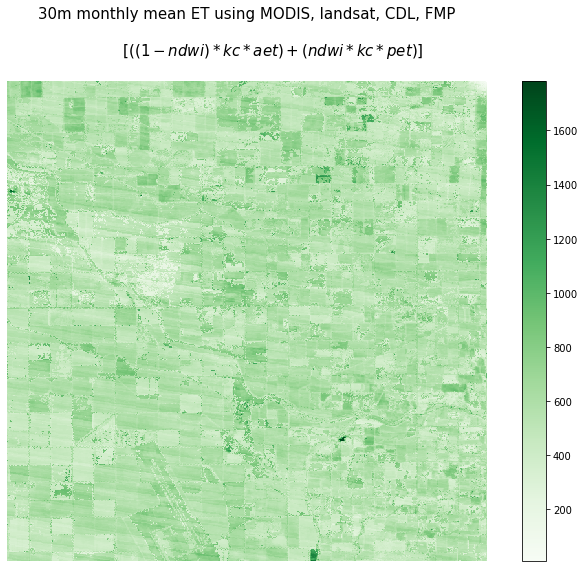

In [33]:
plt.figure(figsize=(10,8))
plt.suptitle("")
plt.title("""30m monthly mean ET using MODIS, landsat, CDL, FMP

           $ [ ((1-ndwi)*kc*aet) + (ndwi*kc*pet) ]  $
            """, size = 15)
plt.imshow( (aet_rs_mean*kc_mean* (1-normalize_array(ndwi_im)) ) + ( pet_rs_mean*kc_mean* normalize_array(ndwi_im))   , cmap = 'Greens')

plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

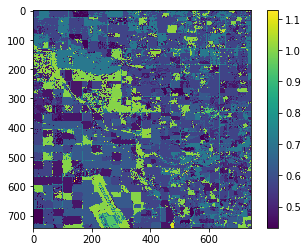

In [36]:
plt.imshow(kc_mean)
plt.colorbar()

In [ ]:
print(np.nanmean((aet_rs_mean*kc_mean* (1-normalize_array(ndwi_im)) ) + ( pet_rs_mean*kc_mean* normalize_array(ndwi_im))))
print(np.nanmean((aet_rs_mean*kc_mean* (1-(ndwi_im)) ) + ( pet_rs_mean*kc_mean* (ndwi_im))))

In [ ]:
t = (aet_rs_mean*kc_mean* (1-normalize_array(ndwi_im)) ) + ( pet_rs_mean*kc_mean* normalize_array(ndwi_im)) 

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(t[450:540, 560:640], cmap = 'jet')
plt.colorbar()

In [ ]:
plt.plot([x[484:486,611:613].mean() for x in mETs])

In [ ]:
for i in mETs:
    print(np.min(i[480:490,610:620]))
    print(np.median(i[480:490,610:620]))
    print(np.mean(i[480:490,610:620]))
    print(np.max(i[480:490,610:620]))
    plt.imshow(i[480:490,610:620])
    plt.colorbar()
    plt.show()
    plt.imshow(kc_im[480:490,610:620])
    plt.colorbar()
    plt.show()
    plt.imshow(ndwi_im[480:490,610:620])
    plt.colorbar()
    plt.show()


In [ ]:
files = [os.path.join("../data/wET",x) for x in os.listdir("../data/wET") if x.endswith(".csv")]

In [ ]:
dfs = [pd.read_csv(x) for x in files]

In [ ]:
wdfs = [x.wET for x in dfs]
petdfs = [x.pet for x in dfs]
aetdfs = [x.aet for x in dfs]
kcdfs = [x.kc for x in dfs]
wET = pd.concat(wdfs, axis = 1)
aet = pd.concat(aetdfs, axis = 1)
pet = pd.concat(petdfs, axis = 1)
kc = pd.concat(kcdfs, axis = 1)

In [ ]:
wets = wET.sum(axis=1)
pets = pet.sum(axis=1)
aets = aet.sum(axis=1)
kcs = kc.mean(axis = 1)

In [ ]:
plt.plot(wets)

In [ ]:
wdf = pd.DataFrame([wets, pets, aets, kcs]).T
wdf.index = pd.to_datetime(dfs[0][dfs[0].columns[0]])

wdf.columns = ['wET', 'pet', 'aet', "kc"]

In [ ]:
wdf['kcpet'] = wdf.pet * wdf.kc

In [ ]:
wdf.plot()